#Ce notebook présente les optimisations liées à un algorithme qui ajuste dynamiquement le Learning Rate

In [ ]:
import os 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras import Model 
import matplotlib.pyplot as plt

import tensorflow

In [ ]:
import pandas as pd
import pathlib

df = pd.read_csv ("20genusmax.csv")

path = r"G:/champybis"
df.path = path+df.path

In [ ]:
# suppression des images corrompues ou inexistantes

from PIL import Image


for i in range (len(df)-1, -1, -1):
    try:
        imgpath = df["path"].iloc[i]
        Image.open(imgpath)
        print(i)

    except:
        print('Error occur on ' + imgpath)
        if os.path.exists (imgpath):
            os.remove(imgpath)
        df = df.drop (df.index[i])

In [ ]:
sample_per_classe = 4000

sub_c1 = df[df["genus"] == "Cortinarius"].iloc[0:sample_per_classe]
sub_c2 = df[df["genus"] == "Lactarius"].iloc[0:sample_per_classe]
sub_c3 = df[df["genus"] == "Pleurotus"].iloc[0:sample_per_classe]
sub_c4 = df[df["genus"] == "Suillus"].iloc[0:sample_per_classe]
sub_c5 = df[df["genus"] == "Tricholoma"].iloc[0:sample_per_classe]
sub_c6 = df[df["genus"] == "Coprinellus"].iloc[0:sample_per_classe]
sub_c7 = df[df["genus"] == "Mycena"].iloc[0:sample_per_classe]
sub_c8 = df[df["genus"] == "Amanita"].iloc[0:sample_per_classe]
sub_c9 = df[df["genus"] == "Russula"].iloc[0:sample_per_classe]
sub_c10 = df[df["genus"] == "Cerioporus"].iloc[0:sample_per_classe]
sub_c11 = df[df["genus"] == "Ganoderma"].iloc[0:sample_per_classe]
sub_c12 = df[df["genus"] == "Hygrocybe"].iloc[0:sample_per_classe]
sub_c13 = df[df["genus"] == "Trametes"].iloc[0:sample_per_classe]
sub_c14 = df[df["genus"] == "Schizophyllum"].iloc[0:sample_per_classe]
sub_c15 = df[df["genus"] == "Stereum"].iloc[0:sample_per_classe]
sub_c16 = df[df["genus"] == "Fomes"].iloc[0:sample_per_classe]
sub_c17 = df[df["genus"] == "Entoloma"].iloc[0:sample_per_classe]
sub_c18 = df[df["genus"] == "Fomitopsis"].iloc[0:sample_per_classe]
sub_c19 = df[df["genus"] == "Hypholoma"].iloc[0:sample_per_classe]
sub_c20 = df[df["genus"] == "Boletus"].iloc[0:sample_per_classe]
sub_c21 = df[df["genus"] == "Laetiporus"].iloc[0:sample_per_classe]
sub_c22 = df[df["genus"] == "Lycoperdon"].iloc[0:sample_per_classe]

liste = [sub_c1, sub_c2, sub_c3, sub_c4, sub_c5,
                  sub_c6, sub_c7, sub_c8, sub_c9, sub_c10,sub_c11,sub_c12,sub_c13,
                  sub_c14,sub_c15,sub_c16,sub_c17,sub_c18,sub_c19,sub_c20,sub_c21,sub_c22]
num_class = len(liste) # travail sur 22 classes, cette variable servira à la compilation du modèle
data = pd.concat(liste)

from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(data, test_size = 0.2)

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input

train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rotation_range = 180,) # une seule transformation


# Générateur d'images pour le test
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)



# Entrainment depuis des images données dans un dataset
batch_size =150  # accordé à la Vram
train_generator = train_datagen.flow_from_dataframe(dataframe=data_train,
                                                    directory = "",
                                                    x_col = "path",
                                                    y_col = "genus",
                                                    batch_size = batch_size,
                                                    class_mode = 'sparse', 
                                                    target_size = (224, 224))

# Validation avec les images de test sur le HDD
validation_generator = test_datagen.flow_from_dataframe(dataframe=data_test,
                                                        directory="",
                                                        x_col = "path",
                                                        y_col = "genus",
                                                        batch_size = batch_size,
                                                        class_mode = 'sparse',
                                                        target_size = (224, 224))


In [ ]:

rom tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.models import Sequential

base_model = VGG16(input_shape=(224, 224,3), 
                      include_top=False, 
                      weights="imagenet")

for layer in base_model.layers:
    layer.trainable = False
    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(units = 1024, activation = 'relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units = num_class, activation = 'softmax'))


model.compile(optimizer = "adam", #optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001), 
                   loss = 'sparse_categorical_crossentropy', #loss = 'binary_crossentropy', 
                   metrics = ['acc'])

In [ ]:
# définition des callback d'interruption des epochs et d'enregistrement des poids du modèle
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,Callback, ReduceLROnPlateau

early = EarlyStopping(monitor='val_loss', #métrique interressante car elle évolue plus souvent que val_acc
                      min_delta=0.0001, 
                      patience=20, 
                      verbose=1, 
                      mode='auto') # s'adapte à la métrique choisie


logs = Callback()

checkpoint_path = "vgg16train20genus/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# ne sauvegarde que l'essentiel
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True, # pratique pour ne garder que le meilleur score
                                                 verbose=1)

## ReduceLROnPlateau

Quelques explications :

moniteur : scoring à surveiller, val_acc et loss_acc ont été testés
Factor : 0.01 a été testé, l'entraînement s'interrompt assez vite avec un score n'évoluant pas. Changement trop grand. 
Patience : Une variable interressante pour rendre plus aggressif (et moins précis) le changement de lr, il est resté à deux
min_delta : choisi pour correspondre aux valeurs de scoring observables, par defaut 0.0001
cooldown : essai entre 0 et 1. 1 est un peu plus long, mais les résultats obtenus sont moins oscillant. 

Il fut très interressant de lancer Rlr une fois le modèle entrainé à une précision de 0.82 (10 epochs). A partir de la, il fut plus rapide de le relancer plusieurs fois avec d'autres paramètres pour ce callback.

In [ ]:
# les paramètres définies laisseront le temps à l'entrainement du modèle de se stabiliser. 
lr_plateau = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=4,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=1,
    min_lr=0,

)

In [ ]:
# Entrainement du modèle
history = model.fit_generator(train_generator, 
                         validation_data = validation_generator, 
                         steps_per_epoch = train_generator.samples // batch_size,
                         validation_steps= validation_generator.samples // batch_size,   
                         epochs = 50,
                         callbacks=[early,logs,lr_plateau,cp_callback]
                         
                   )

In [ ]:
# Chargement du modèle, pratique en cas de recompilation pour modifier le Lr sans perdre son score
model.load_weights(checkpoint_path)

log obtenu (ne pas hésiter à double cliquer pour obtenir une meilleure lisibilité):

Epoch 1/50
468/469 [============================>.] - ETA: 1s - loss: 2.0469 - acc: 0.3677   Epoch 1/50
117/469 [======>.......................] - ETA: 3:26 - loss: 1.5484 - acc: 0.5104 
Epoch 00001: val_loss improved from inf to 1.54838, saving model to vgg16train20genus/cp.ckpt
469/469 [==============================] - 811s 2s/step - loss: 2.0467 - acc: 0.3677 - val_loss: 1.5484 - val_acc: 0.5104
Epoch 2/50
468/469 [============================>.] - ETA: 1s - loss: 1.7306 - acc: 0.4629  Epoch 1/50
117/469 [======>.......................] - ETA: 2:04 - loss: 1.4337 - acc: 0.5497
Epoch 00002: val_loss improved from 1.54838 to 1.43373, saving model to vgg16train20genus/cp.ckpt
469/469 [==============================] - 606s 1s/step - loss: 1.7306 - acc: 0.4629 - val_loss: 1.4337 - val_acc: 0.5497
Epoch 3/50
468/469 [============================>.] - ETA: 1s - loss: 1.6185 - acc: 0.4956  Epoch 1/50
117/469 [======>.......................] - ETA: 2:04 - loss: 1.3751 - acc: 0.5713
Epoch 00003: val_loss improved from 1.43373 to 1.37505, saving model to vgg16train20genus/cp.ckpt
469/469 [==============================] - 601s 1s/step - loss: 1.6183 - acc: 0.4958 - val_loss: 1.3751 - val_acc: 0.5713
Epoch 4/50
468/469 [============================>.] - ETA: 1s - loss: 1.5571 - acc: 0.5158  Epoch 1/50
117/469 [======>.......................] - ETA: 2:18 - loss: 1.3376 - acc: 0.5822
Epoch 00004: val_loss improved from 1.37505 to 1.33758, saving model to vgg16train20genus/cp.ckpt
469/469 [==============================] - 702s 1s/step - loss: 1.5572 - acc: 0.5158 - val_loss: 1.3376 - val_acc: 0.5822
Epoch 5/50
468/469 [============================>.] - ETA: 1s - loss: 1.5144 - acc: 0.5315  Epoch 1/50
117/469 [======>.......................] - ETA: 2:04 - loss: 1.3210 - acc: 0.5870
Epoch 00005: val_loss improved from 1.33758 to 1.32101, saving model to vgg16train20genus/cp.ckpt
469/469 [==============================] - 727s 2s/step - loss: 1.5147 - acc: 0.5315 - val_loss: 1.3210 - val_acc: 0.5870
Epoch 6/50
468/469 [============================>.] - ETA: 1s - loss: 1.4704 - acc: 0.5418  Epoch 1/50
117/469 [======>.......................] - ETA: 2:04 - loss: 1.3009 - acc: 0.5880
Epoch 00006: val_loss improved from 1.32101 to 1.30086, saving model to vgg16train20genus/cp.ckpt
469/469 [==============================] - 606s 1s/step - loss: 1.4700 - acc: 0.5419 - val_loss: 1.3009 - val_acc: 0.5880
Epoch 7/50
468/469 [============================>.] - ETA: 1s - loss: 1.4448 - acc: 0.5519  Epoch 1/50
117/469 [======>.......................] - ETA: 3:04 - loss: 1.2618 - acc: 0.6035
Epoch 00007: val_loss improved from 1.30086 to 1.26184, saving model to vgg16train20genus/cp.ckpt
469/469 [==============================] - 646s 1s/step - loss: 1.4448 - acc: 0.5518 - val_loss: 1.2618 - val_acc: 0.6035
Epoch 8/50
468/469 [============================>.] - ETA: 1s - loss: 1.4142 - acc: 0.5609   Epoch 1/50
117/469 [======>.......................] - ETA: 2:04 - loss: 1.2787 - acc: 0.5991
Epoch 00008: val_loss did not improve from 1.26184
469/469 [==============================] - 779s 2s/step - loss: 1.4146 - acc: 0.5609 - val_loss: 1.2787 - val_acc: 0.5991
Epoch 9/50
468/469 [============================>.] - ETA: 1s - loss: 1.3967 - acc: 0.5639  Epoch 1/50
117/469 [======>.......................] - ETA: 2:03 - loss: 1.2632 - acc: 0.6037
Epoch 00009: val_loss did not improve from 1.26184
469/469 [==============================] - 590s 1s/step - loss: 1.3967 - acc: 0.5640 - val_loss: 1.2632 - val_acc: 0.6037
Epoch 10/50
468/469 [============================>.] - ETA: 1s - loss: 1.3719 - acc: 0.5728  Epoch 1/50
117/469 [======>.......................] - ETA: 2:03 - loss: 1.2474 - acc: 0.6079
Epoch 00010: val_loss improved from 1.26184 to 1.24743, saving model to vgg16train20genus/cp.ckpt
469/469 [==============================] - 590s 1s/step - loss: 1.3719 - acc: 0.5728 - val_loss: 1.2474 - val_acc: 0.6079
Epoch 11/50
468/469 [============================>.] - ETA: 1s - loss: 1.3557 - acc: 0.5761  Epoch 1/50
117/469 [======>.......................] - ETA: 2:03 - loss: 1.2411 - acc: 0.6090
Epoch 00011: val_loss improved from 1.24743 to 1.24105, saving model to vgg16train20genus/cp.ckpt
469/469 [==============================] - 576s 1s/step - loss: 1.3558 - acc: 0.5761 - val_loss: 1.2411 - val_acc: 0.6090
Epoch 12/50
468/469 [============================>.] - ETA: 1s - loss: 1.3338 - acc: 0.5830  Epoch 1/50
117/469 [======>.......................] - ETA: 2:03 - loss: 1.2339 - acc: 0.6144
Epoch 00012: val_loss improved from 1.24105 to 1.23389, saving model to vgg16train20genus/cp.ckpt
469/469 [==============================] - 571s 1s/step - loss: 1.3338 - acc: 0.5830 - val_loss: 1.2339 - val_acc: 0.6144
Epoch 13/50
468/469 [============================>.] - ETA: 1s - loss: 1.3172 - acc: 0.5899  Epoch 1/50
117/469 [======>.......................] - ETA: 2:03 - loss: 1.2338 - acc: 0.6174
Epoch 00013: val_loss improved from 1.23389 to 1.23384, saving model to vgg16train20genus/cp.ckpt
469/469 [==============================] - 570s 1s/step - loss: 1.3173 - acc: 0.5899 - val_loss: 1.2338 - val_acc: 0.6174
Epoch 14/50
468/469 [============================>.] - ETA: 1s - loss: 1.3017 - acc: 0.5925  Epoch 1/50
117/469 [======>.......................] - ETA: 2:03 - loss: 1.2224 - acc: 0.6188
Epoch 00014: val_loss improved from 1.23384 to 1.22241, saving model to vgg16train20genus/cp.ckpt
469/469 [==============================] - 567s 1s/step - loss: 1.3015 - acc: 0.5925 - val_loss: 1.2224 - val_acc: 0.6188
Epoch 15/50
468/469 [============================>.] - ETA: 1s - loss: 1.2871 - acc: 0.5981  Epoch 1/50
117/469 [======>.......................] - ETA: 2:03 - loss: 1.2229 - acc: 0.6176
Epoch 00015: val_loss did not improve from 1.22241
469/469 [==============================] - 566s 1s/step - loss: 1.2869 - acc: 0.5981 - val_loss: 1.2229 - val_acc: 0.6176
Epoch 16/50
468/469 [============================>.] - ETA: 1s - loss: 1.2701 - acc: 0.6022  Epoch 1/50
117/469 [======>.......................] - ETA: 2:03 - loss: 1.2236 - acc: 0.6219
Epoch 00016: val_loss did not improve from 1.22241
469/469 [==============================] - 569s 1s/step - loss: 1.2704 - acc: 0.6022 - val_loss: 1.2236 - val_acc: 0.6219
Epoch 17/50
468/469 [============================>.] - ETA: 1s - loss: 1.2595 - acc: 0.6065  Epoch 1/50
117/469 [======>.......................] - ETA: 2:03 - loss: 1.2129 - acc: 0.6214
Epoch 00017: val_loss improved from 1.22241 to 1.21290, saving model to vgg16train20genus/cp.ckpt
469/469 [==============================] - 565s 1s/step - loss: 1.2593 - acc: 0.6066 - val_loss: 1.2129 - val_acc: 0.6214
Epoch 18/50
468/469 [============================>.] - ETA: 1s - loss: 1.2522 - acc: 0.6069  Epoch 1/50
117/469 [======>.......................] - ETA: 2:03 - loss: 1.2032 - acc: 0.6264
Epoch 00018: val_loss improved from 1.21290 to 1.20323, saving model to vgg16train20genus/cp.ckpt
469/469 [==============================] - 566s 1s/step - loss: 1.2526 - acc: 0.6067 - val_loss: 1.2032 - val_acc: 0.6264
Epoch 19/50
468/469 [============================>.] - ETA: 1s - loss: 1.2431 - acc: 0.6114  Epoch 1/50
117/469 [======>.......................] - ETA: 2:03 - loss: 1.2007 - acc: 0.6250
Epoch 00019: val_loss improved from 1.20323 to 1.20075, saving model to vgg16train20genus/cp.ckpt
469/469 [==============================] - 566s 1s/step - loss: 1.2426 - acc: 0.6116 - val_loss: 1.2007 - val_acc: 0.6250
Epoch 20/50
468/469 [============================>.] - ETA: 1s - loss: 1.2324 - acc: 0.6125  Epoch 1/50
117/469 [======>.......................] - ETA: 2:03 - loss: 1.2047 - acc: 0.6232
Epoch 00020: val_loss did not improve from 1.20075
469/469 [==============================] - 563s 1s/step - loss: 1.2323 - acc: 0.6126 - val_loss: 1.2047 - val_acc: 0.6232
Epoch 21/50
468/469 [============================>.] - ETA: 1s - loss: 1.2130 - acc: 0.6158  Epoch 1/50
117/469 [======>.......................] - ETA: 2:03 - loss: 1.2032 - acc: 0.6286
Epoch 00021: val_loss did not improve from 1.20075
469/469 [==============================] - 564s 1s/step - loss: 1.2134 - acc: 0.6157 - val_loss: 1.2032 - val_acc: 0.6286
Epoch 22/50
468/469 [============================>.] - ETA: 1s - loss: 1.2112 - acc: 0.6209  Epoch 1/50
117/469 [======>.......................] - ETA: 2:03 - loss: 1.2048 - acc: 0.6268
Epoch 00022: val_loss did not improve from 1.20075
469/469 [==============================] - 564s 1s/step - loss: 1.2115 - acc: 0.6209 - val_loss: 1.2048 - val_acc: 0.6268
Epoch 23/50
468/469 [============================>.] - ETA: 1s - loss: 1.2022 - acc: 0.6226  Epoch 1/50
117/469 [======>.......................] - ETA: 2:03 - loss: 1.1875 - acc: 0.6302
Epoch 00023: val_loss improved from 1.20075 to 1.18751, saving model to vgg16train20genus/cp.ckpt
469/469 [==============================] - 563s 1s/step - loss: 1.2020 - acc: 0.6227 - val_loss: 1.1875 - val_acc: 0.6302
Epoch 24/50
468/469 [============================>.] - ETA: 1s - loss: 1.1924 - acc: 0.6252  Epoch 1/50
117/469 [======>.......................] - ETA: 2:03 - loss: 1.1971 - acc: 0.6277
Epoch 00024: val_loss did not improve from 1.18751
469/469 [==============================] - 569s 1s/step - loss: 1.1922 - acc: 0.6253 - val_loss: 1.1971 - val_acc: 0.6277
Epoch 25/50
468/469 [============================>.] - ETA: 1s - loss: 1.1860 - acc: 0.6248  Epoch 1/50
117/469 [======>.......................] - ETA: 2:03 - loss: 1.1945 - acc: 0.6303
Epoch 00025: val_loss did not improve from 1.18751
469/469 [==============================] - 563s 1s/step - loss: 1.1864 - acc: 0.6246 - val_loss: 1.1945 - val_acc: 0.6303
Epoch 26/50
468/469 [============================>.] - ETA: 1s - loss: 1.1699 - acc: 0.6308  Epoch 1/50
117/469 [======>.......................] - ETA: 2:03 - loss: 1.1985 - acc: 0.6258
Epoch 00026: val_loss did not improve from 1.18751
469/469 [==============================] - 563s 1s/step - loss: 1.1700 - acc: 0.6308 - val_loss: 1.1985 - val_acc: 0.6258
Epoch 27/50
468/469 [============================>.] - ETA: 1s - loss: 1.1694 - acc: 0.6317  Epoch 1/50
117/469 [======>.......................] - ETA: 2:03 - loss: 1.2198 - acc: 0.6227
Epoch 00027: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00027: val_loss did not improve from 1.18751
469/469 [==============================] - 567s 1s/step - loss: 1.1693 - acc: 0.6317 - val_loss: 1.2198 - val_acc: 0.6227
Epoch 28/50
468/469 [============================>.] - ETA: 1s - loss: 1.0817 - acc: 0.6565  Epoch 1/50
117/469 [======>.......................] - ETA: 2:03 - loss: 1.1639 - acc: 0.6421
Epoch 00028: val_loss improved from 1.18751 to 1.16393, saving model to vgg16train20genus/cp.ckpt
469/469 [==============================] - 562s 1s/step - loss: 1.0813 - acc: 0.6566 - val_loss: 1.1639 - val_acc: 0.6421
Epoch 29/50
468/469 [============================>.] - ETA: 1s - loss: 1.0472 - acc: 0.6661  Epoch 1/50
117/469 [======>.......................] - ETA: 2:03 - loss: 1.1637 - acc: 0.6449
Epoch 00029: val_loss improved from 1.16393 to 1.16368, saving model to vgg16train20genus/cp.ckpt
469/469 [==============================] - 567s 1s/step - loss: 1.0472 - acc: 0.6660 - val_loss: 1.1637 - val_acc: 0.6449
Epoch 30/50
468/469 [============================>.] - ETA: 1s - loss: 1.0303 - acc: 0.6694  Epoch 1/50
117/469 [======>.......................] - ETA: 2:03 - loss: 1.1616 - acc: 0.6459
Epoch 00030: val_loss improved from 1.16368 to 1.16156, saving model to vgg16train20genus/cp.ckpt
469/469 [==============================] - 559s 1s/step - loss: 1.0302 - acc: 0.6694 - val_loss: 1.1616 - val_acc: 0.6459
Epoch 31/50
468/469 [============================>.] - ETA: 1s - loss: 1.0300 - acc: 0.6705  Epoch 1/50
117/469 [======>.......................] - ETA: 2:03 - loss: 1.1556 - acc: 0.6471
Epoch 00031: val_loss improved from 1.16156 to 1.15560, saving model to vgg16train20genus/cp.ckpt
469/469 [==============================] - 561s 1s/step - loss: 1.0302 - acc: 0.6704 - val_loss: 1.1556 - val_acc: 0.6471
Epoch 32/50
468/469 [============================>.] - ETA: 1s - loss: 1.0176 - acc: 0.6735  Epoch 1/50
117/469 [======>.......................] - ETA: 2:03 - loss: 1.1518 - acc: 0.6500
Epoch 00032: val_loss improved from 1.15560 to 1.15181, saving model to vgg16train20genus/cp.ckpt
469/469 [==============================] - 566s 1s/step - loss: 1.0175 - acc: 0.6734 - val_loss: 1.1518 - val_acc: 0.6500
Epoch 33/50
468/469 [============================>.] - ETA: 1s - loss: 1.0208 - acc: 0.6743  Epoch 1/50
117/469 [======>.......................] - ETA: 2:03 - loss: 1.1520 - acc: 0.6502
Epoch 00033: val_loss did not improve from 1.15181
469/469 [==============================] - 559s 1s/step - loss: 1.0209 - acc: 0.6743 - val_loss: 1.1520 - val_acc: 0.6502
Epoch 34/50
468/469 [============================>.] - ETA: 1s - loss: 1.0107 - acc: 0.6777  Epoch 1/50
117/469 [======>.......................] - ETA: 2:03 - loss: 1.1529 - acc: 0.6504
Epoch 00034: val_loss did not improve from 1.15181
469/469 [==============================] - 560s 1s/step - loss: 1.0105 - acc: 0.6778 - val_loss: 1.1529 - val_acc: 0.6504
Epoch 35/50
468/469 [============================>.] - ETA: 1s - loss: 1.0037 - acc: 0.6787  Epoch 1/50
117/469 [======>.......................] - ETA: 2:03 - loss: 1.1514 - acc: 0.6501
Epoch 00035: val_loss improved from 1.15181 to 1.15135, saving model to vgg16train20genus/cp.ckpt
469/469 [==============================] - 562s 1s/step - loss: 1.0035 - acc: 0.6788 - val_loss: 1.1514 - val_acc: 0.6501
Epoch 36/50
468/469 [============================>.] - ETA: 1s - loss: 0.9956 - acc: 0.6801  Epoch 1/50
117/469 [======>.......................] - ETA: 2:03 - loss: 1.1542 - acc: 0.6502
Epoch 00036: val_loss did not improve from 1.15135
469/469 [==============================] - 562s 1s/step - loss: 0.9956 - acc: 0.6801 - val_loss: 1.1542 - val_acc: 0.6502
Epoch 37/50
468/469 [============================>.] - ETA: 1s - loss: 1.0021 - acc: 0.6791  Epoch 1/50
117/469 [======>.......................] - ETA: 2:03 - loss: 1.1489 - acc: 0.6511
Epoch 00037: val_loss improved from 1.15135 to 1.14895, saving model to vgg16train20genus/cp.ckpt
469/469 [==============================] - 562s 1s/step - loss: 1.0019 - acc: 0.6792 - val_loss: 1.1489 - val_acc: 0.6511
Epoch 38/50
468/469 [============================>.] - ETA: 1s - loss: 0.9905 - acc: 0.6806  Epoch 1/50
117/469 [======>.......................] - ETA: 2:03 - loss: 1.1500 - acc: 0.6509
Epoch 00038: val_loss did not improve from 1.14895
469/469 [==============================] - 559s 1s/step - loss: 0.9908 - acc: 0.6805 - val_loss: 1.1500 - val_acc: 0.6509
Epoch 39/50
468/469 [============================>.] - ETA: 1s - loss: 0.9941 - acc: 0.6812  Epoch 1/50
117/469 [======>.......................] - ETA: 2:03 - loss: 1.1461 - acc: 0.6493
Epoch 00039: val_loss improved from 1.14895 to 1.14614, saving model to vgg16train20genus/cp.ckpt
469/469 [==============================] - 560s 1s/step - loss: 0.9940 - acc: 0.6812 - val_loss: 1.1461 - val_acc: 0.6493
Epoch 40/50
468/469 [============================>.] - ETA: 1s - loss: 0.9807 - acc: 0.6858  Epoch 1/50
117/469 [======>.......................] - ETA: 2:03 - loss: 1.1450 - acc: 0.6513
Epoch 00040: val_loss improved from 1.14614 to 1.14505, saving model to vgg16train20genus/cp.ckpt
469/469 [==============================] - 564s 1s/step - loss: 0.9807 - acc: 0.6858 - val_loss: 1.1450 - val_acc: 0.6513
Epoch 41/50
468/469 [============================>.] - ETA: 1s - loss: 0.9772 - acc: 0.6833  Epoch 1/50
117/469 [======>.......................] - ETA: 2:03 - loss: 1.1472 - acc: 0.6497
Epoch 00041: val_loss did not improve from 1.14505
469/469 [==============================] - 560s 1s/step - loss: 0.9772 - acc: 0.6834 - val_loss: 1.1472 - val_acc: 0.6497
Epoch 42/50
468/469 [============================>.] - ETA: 1s - loss: 0.9741 - acc: 0.6875  Epoch 1/50
117/469 [======>.......................] - ETA: 2:02 - loss: 1.1492 - acc: 0.6499
Epoch 00042: val_loss did not improve from 1.14505
469/469 [==============================] - 564s 1s/step - loss: 0.9742 - acc: 0.6875 - val_loss: 1.1492 - val_acc: 0.6499
Epoch 43/50
468/469 [============================>.] - ETA: 1s - loss: 0.9736 - acc: 0.6860  Epoch 1/50
117/469 [======>.......................] - ETA: 2:02 - loss: 1.1466 - acc: 0.6519
Epoch 00043: val_loss did not improve from 1.14505
469/469 [==============================] - 563s 1s/step - loss: 0.9736 - acc: 0.6860 - val_loss: 1.1466 - val_acc: 0.6519
Epoch 44/50
468/469 [============================>.] - ETA: 1s - loss: 0.9811 - acc: 0.6820  Epoch 1/50
117/469 [======>.......................] - ETA: 2:03 - loss: 1.1437 - acc: 0.6519
Epoch 00044: val_loss improved from 1.14505 to 1.14373, saving model to vgg16train20genus/cp.ckpt
469/469 [==============================] - 560s 1s/step - loss: 0.9811 - acc: 0.6820 - val_loss: 1.1437 - val_acc: 0.6519
Epoch 45/50
468/469 [============================>.] - ETA: 1s - loss: 0.9717 - acc: 0.6858  Epoch 1/50
117/469 [======>.......................] - ETA: 2:03 - loss: 1.1422 - acc: 0.6522
Epoch 00045: val_loss improved from 1.14373 to 1.14225, saving model to vgg16train20genus/cp.ckpt
469/469 [==============================] - 563s 1s/step - loss: 0.9718 - acc: 0.6858 - val_loss: 1.1422 - val_acc: 0.6522
Epoch 46/50
468/469 [============================>.] - ETA: 1s - loss: 0.9608 - acc: 0.6906  Epoch 1/50
117/469 [======>.......................] - ETA: 2:03 - loss: 1.1452 - acc: 0.6521
Epoch 00046: val_loss did not improve from 1.14225
469/469 [==============================] - 557s 1s/step - loss: 0.9607 - acc: 0.6906 - val_loss: 1.1452 - val_acc: 0.6521
Epoch 47/50
468/469 [============================>.] - ETA: 1s - loss: 0.9712 - acc: 0.6887  Epoch 1/50
117/469 [======>.......................] - ETA: 2:02 - loss: 1.1410 - acc: 0.6524
Epoch 00047: val_loss improved from 1.14225 to 1.14099, saving model to vgg16train20genus/cp.ckpt
469/469 [==============================] - 563s 1s/step - loss: 0.9712 - acc: 0.6886 - val_loss: 1.1410 - val_acc: 0.6524
Epoch 48/50
468/469 [============================>.] - ETA: 1s - loss: 0.9672 - acc: 0.6901  Epoch 1/50
117/469 [======>.......................] - ETA: 2:02 - loss: 1.1406 - acc: 0.6541
Epoch 00048: val_loss improved from 1.14099 to 1.14056, saving model to vgg16train20genus/cp.ckpt
469/469 [==============================] - 568s 1s/step - loss: 0.9673 - acc: 0.6902 - val_loss: 1.1406 - val_acc: 0.6541
Epoch 49/50
468/469 [============================>.] - ETA: 1s - loss: 0.9603 - acc: 0.6896  Epoch 1/50
117/469 [======>.......................] - ETA: 2:02 - loss: 1.1423 - acc: 0.6524
Epoch 00049: val_loss did not improve from 1.14056
469/469 [==============================] - 560s 1s/step - loss: 0.9600 - acc: 0.6897 - val_loss: 1.1423 - val_acc: 0.6524
Epoch 50/50
468/469 [============================>.] - ETA: 1s - loss: 0.9565 - acc: 0.6921  Epoch 1/50
117/469 [======>.......................] - ETA: 2:03 - loss: 1.1442 - acc: 0.6519
Epoch 00050: val_loss did not improve from 1.14056
469/469 [==============================] - 559s 1s/step - loss: 0.9561 - acc: 0.6922 - val_loss: 1.1442 - val_acc: 0.6519

In [ ]:
# génération des courbes

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(logs.model.history.history['loss'])
plt.plot(logs.model.history.history['val_loss'])
plt.title('Model loss by epoch %i'%sample_per_classe)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(logs.model.history.history['acc'])
plt.plot(logs.model.history.history['val_acc'])
plt.title('Model acc by epoch %i'%sample_per_classe)
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

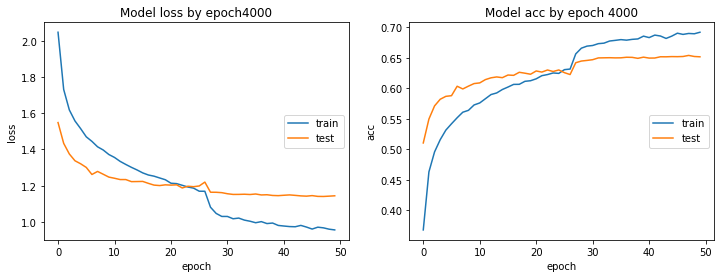

On remarque un pic sur le graphique, le changement du learning rate n'est pas passé inaperçu.
Epoch 00027: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.